In [17]:
import pandas as pd
import MultiContagion as mc
import igraph
import random
import numpy as np
from matplotlib import pylab as plt
import scipy.stats
import copy
#import powerlaw
%matplotlib inline

#### Import network

In [18]:
year = 2015

In [19]:
def make_network(csv_file):
    am = np.genfromtxt (csv_file, delimiter=",")
    df_names =  pd.read_csv('csv_files/all_country_name4.csv', header=None)
    names = list(df_names[0])
    G = igraph.Graph.Weighted_Adjacency(list(am))
    G.vs["name"] = copy.deepcopy(names)
    #to_delete_ids = [v.index for v in G.vs.select(_degree=0)] #will cause bug
    #G.delete_vertices(to_delete_ids)
    return G

In [20]:
g_cdis_eq = make_network('csv_files/AM4_all_nodesNormCDIS-equity'+str(year)+'.csv')
g_cdis_debt = make_network('csv_files/AM4_all_nodesNormCDIS-debt'+str(year)+'.csv')
g_cpis_eq = make_network('csv_files/AM4_all_nodesNormCPIS-equity'+str(year)+'.csv')
g_cpis_debt = make_network('csv_files/AM4_all_nodesNormCPIS-debt'+str(year)+'.csv')
g_bis = make_network('csv_files/AM4_all_nodesNormBIS'+str(year)+'.csv')

In [21]:
G_list = [g_cdis_eq, g_cdis_debt, g_cpis_eq, g_cpis_debt, g_bis ]
G_names =["CDIS equity", "CDIS debt", "CPIS equity", "CPIS debt", "BIS"]

In [22]:
len(g_cdis_eq.vs["name"]);

In [23]:
def Percolation(G, threshold= 0.5 ,chosen_one = -1, count_break = 300):
    '''Percolation mode. A node becomes infected if a fraction of its neighbours is infected.
    Starts with random node, unless specified otherwise.'''
    damp = threshold #(weighted)fraction  of neighbours that must be infected, for node to become infected.
    AM_weight = G.get_adjacency(attribute="weight")
    in_strength_weight = G.strength(weights=G.es["weight"], mode = "IN")
    n_countries = len(AM_weight[0])
    susceptible = [i for i in range(n_countries)]
    
    if chosen_one == -1:
        chosen_one = random.choice(susceptible)
    infected = [[chosen_one]]    
    susceptible.remove(chosen_one)

    count = 0
    for t in range(n_countries): #maximun number of steps simulation can have
        infected.append([])
        for i in range(n_countries):
            weights_infected_neigh = 0
            if i in infected[count]: #if node is infected it will keep being infected.
                infected[count + 1].append(i)
                pass
            else: #if it is not infected we must check on its neighbors
                in_neigh_list = G.vs[i].neighbors(mode = "IN")
                if in_strength_weight[i] == 0:
                    #print i
                    pass
                else:
                    for j in range(len(in_neigh_list)):
                        graph_index = in_neigh_list[j].index   
                 
                        if graph_index in infected[count]:
                            weights_infected_neigh +=AM_weight[graph_index][i]
                        
                    #compute fraction of weights coming from neighbors which are infected
                    
                    frac_weight_inf_neigh = float(weights_infected_neigh)/in_strength_weight[i]
    
                
                    if frac_weight_inf_neigh > threshold:
                        infected[count + 1].append(i)
                        susceptible.remove(i)
                    
        count += 1            
        
        if len(infected[t]) == len(infected[t + 1]):
            break
        if count > count_break:
            print "warning"
            break
                
    return infected

In [24]:
countries_name_starting = ["United States", "United Kingdom", "Netherlands", "Luxembourg", "Germany", "Ireland", "Japan", "France", "Switzerland", "Canada", "Bermuda", "Belgium", "Spain", "Italy", "Gibraltar", "Jersey", "Cayman Islands", "Sweden", "Australia", "China P.R.: Hong Kong" ]

In [25]:
countries_name_starting = [ "United States","United Kingdom", "Netherlands", "Luxembourg", "China  P.R.: Hong Kong", "Germany" ]

In [26]:
def countries_starting_num(countries_name_starting, g):
    c_list = []
    for c in countries_name_starting:
        c_list.append(g.vs["name"].index(c))
    return c_list

In [27]:
countries_starting = countries_starting_num(countries_name_starting, g_bis)

In [28]:
def make_thresholds_constant(ti = 0.1, tf = 0.8 , steps = 5, layers = 5):
    T = []
    for t in np.linspace(ti, tf, steps):
        T.append([round(t, 2), [round(t, 2) for i in range(layers)]])
    return T

In [29]:
#countries_starting = [220, 219, 150, 124] #US, UK
threshold_list = [i*0.05 for i in range(1,10)]
threshold_list = [i*0.1 for i in range(1,10)]

## Percolation for plots

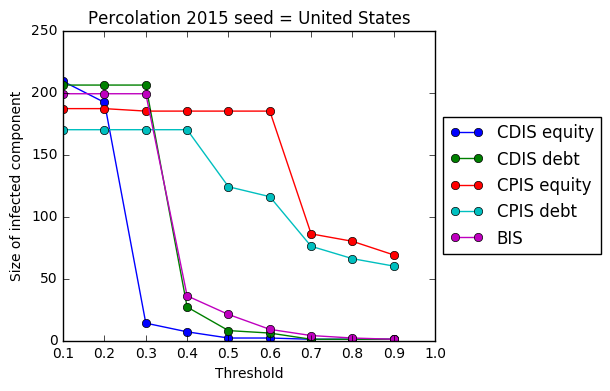

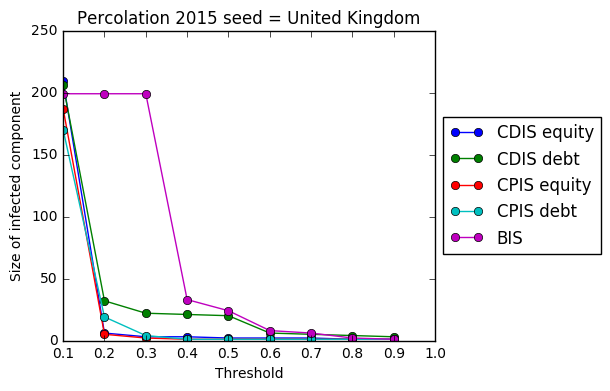

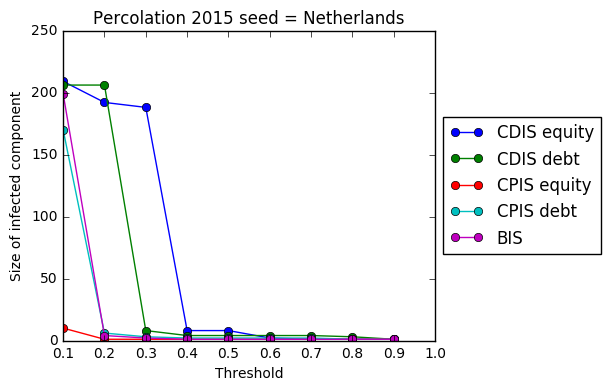

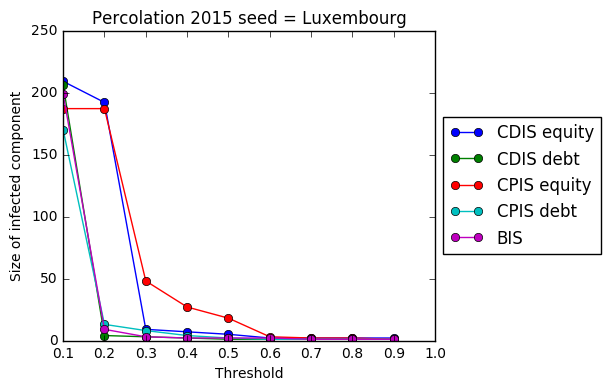

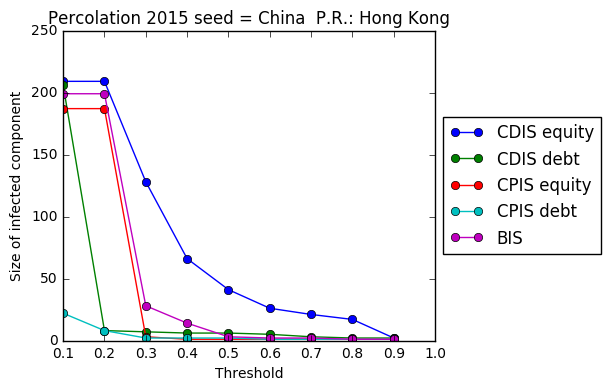

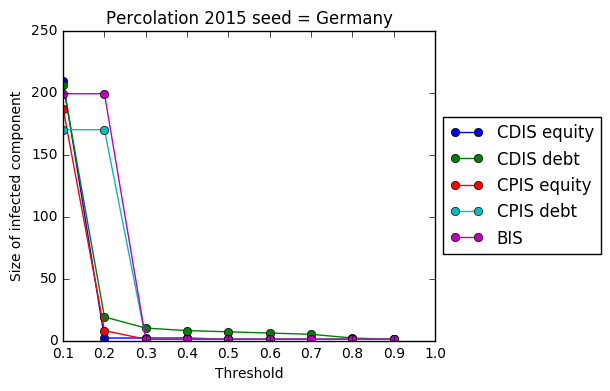

In [30]:
for c in countries_starting:
    fig = plt.figure()
    ax = plt.subplot(111)
    size_graphs = []
    count = 0
    count2 = 0
    for g in G_list:
        size = []
        for T in threshold_list:
            perco = Percolation(g, threshold= T, chosen_one= c)
            
            size.append(len(perco[-1]))
        size_graphs.append(size)
        plt.plot(threshold_list, size_graphs[count2], "o-", label = G_names[count2])
        count2+= 1
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    plt.title("Percolation "+str(year)+" seed = "+ g.vs["name"][c])
    count += 1
    plt.xlabel("Threshold")
    plt.ylabel("Size of infected component")    
    plt.savefig("fig/ContagionMonoplex_"+ g.vs["name"][c]+str(year) +".png",bbox_inches='tight') 
    plt.show()


## Percolation for csv files

In [31]:
def Percolation_tocsv(G, g_name, threshold= 0.5 ,chosen_one = -1, count_break = 300):
    '''Percolation mode. A node becomes infected if a fraction of its neighbours is infected.
    Starts with random node, unless specified otherwise.'''
    damp = threshold #(weighted)fraction  of neighbours that must be infected, for node to become infected.
    AM_weight = G.get_adjacency(attribute="weight")
    in_strength_weight = G.strength(weights=G.es["weight"], mode = "IN")
    n_countries = len(AM_weight[0])
    susceptible = [i for i in range(n_countries)]
    
    if chosen_one == -1:
        chosen_one = random.choice(susceptible)
    seed_country_name = G.vs["name"][chosen_one]   
    infected = [[chosen_one]]    
    susceptible.remove(chosen_one)
    f = open("csv_files/Contagion"+g_name+"_th"+str(threshold)+seed_country_name+str(year)+".csv", "w")
    f.write("time step, countries that become infected \n")
    count = 0
    for t in range(n_countries): #maximun number of steps simulation can have
        infected.append([])
        for i in range(n_countries):
            weights_infected_neigh = 0
            if i in infected[count]: #if node is infected it will keep being infected.
                infected[count + 1].append(i)
                pass
            else: #if it is not infected we must check on its neighbors
                in_neigh_list = G.vs[i].neighbors(mode = "IN")
                if in_strength_weight[i] == 0:
                    #print i
                    pass
                else:
                    for j in range(len(in_neigh_list)):
                        graph_index = in_neigh_list[j].index   
                 
                        if graph_index in infected[count]:
                            weights_infected_neigh +=AM_weight[graph_index][i]
                        
                    #compute fraction of weights coming from neighbors which are infected
                    
                    frac_weight_inf_neigh = float(weights_infected_neigh)/in_strength_weight[i]
    
                
                    if frac_weight_inf_neigh > threshold:
                        infected[count + 1].append(i)
                        f.write(str(t) +","+ G.vs["name"][i]+ "\n")
                        susceptible.remove(i)
                    
        count += 1            
        
        if len(infected[t]) == len(infected[t + 1]):
            break
        if count > count_break:
            print "warning"
            break
    f.close()           
    return infected

In [32]:
for c in countries_starting:
    count = 0
    count2 = 0
    for g in G_list:
        size = []
        for T in threshold_list:
            perco = Percolation_tocsv(g, G_names[count2] ,threshold= T, chosen_one= c)
        count+=1